<a href="https://colab.research.google.com/github/MINDS-edu/The-5th-POSTECH-Youth-Mathematical-Artificial-Intelligence-Academy/blob/master/PYMAIA5_day2_MLP_실습.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 선형회귀 (일차함수)보다 더 복잡한 함수

지난 실습 때는 일차함수를 사용하여 "키로 발 사이즈를 예측하는 모델"을 만들어 봤어요.

키와 발 사이즈는 직선 모양의 관계를 갖고 있었기 때문에 일차 함수 같은 쉬운 함수로도 두 변수 사이의 관계를 잘 나타낼 수 있었어요.

<br>

하지만 이 세상에는 두 변수의 사이의 관계를 직선 모양으로 나타낼 수 없는 경우가 훨씬 많습니다.
- 예시 1) 공부 시간 ($x$)에 따른 시험 성적 ($y$)의 관계
  - 공부를 어느 정도 많이 해야 성적이 오르기 시작
  - 최고 성적 100점으로 제한되어 있음
- 예시 2) 숫자 인식: 주어진 사진 ($x$)에 그려진 숫자 ($y$)가 무엇인지를 나타내는 관계
- 예시 3) ChatGPT: 사용자의 질문 ($x$)과 알맞은 응답 ($y$) 사이의 관계

<br>

예시 2와 3의 경우 $x$와 $y$ 사이의 관계를 과연 우리가 아는 함수로 나타낼 수 있을지 의심부터 들 거예요. 하지만 정답부터 말하면 가능합니다. 현대의 인공지능은 우리가 알고 있는 쉬운 함수 여러 개를 복잡하게 조합하여 만든 함수에 지나지 않습니다. 오늘 배운 다층 퍼셉트론 (multilayer perceptron; MLP)은 간단한 함수들을 조합하여 복잡한 함수를 만드는 방법 중 하나이며, 현대 인공지능 모델들의 부분적인 구성 요소이기도 합니다.

<br>

이번 시간에는 직선 모양의 함수부터 시작해서 우리가 원하는 모양의 함수로 점점 변환해보는 과정을 실습해보며 MLP에 대해 이해를 해볼 것입니다.


<br>

---

## 곡선 모양의 관계를 직선으로 나타낼 수 있을까?

지난 실습 때처럼 일차함수의 기울기 $a$와 $y$절편 $b$를 바꿔서 데이터의 $x$와 $y$ 사이의 관계를 최대한 나타내보세요. 직선만으로 $x$와 $y$ 사이의 관계를 나타낼 수 있나요?

In [1]:
import io
import IPython
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from base64 import b64decode
from google.colab import output
from google.colab.output import eval_js
from keras.datasets import mnist
from IPython.display import display, Javascript, HTML
from PIL import Image
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
x = np.array([-2.000, -1.714, -1.429, -1.143, -0.857, -0.571, -0.286, 0.000, 0.286, 0.571, 0.857, 1.143, 1.429, 1.714, 2.000])
y = np.array([ 0.004,  0.016,  0.048,  0.142,  0.386,  0.858,  1.404, 1.762, 1.918, 1.972, 1.992, 1.998, 2.000, 2.000, 2.000])

In [ ]:
a = 1 # @param {type:"raw"}
b = 0 # @param {type:"raw"}

plt.figure(figsize = (6, 4))
# 데이터 그리기
plt.plot(x, y, 'o', label = 'data')
plt.plot([-3, 3], [-3 * a + b, 3 * a + b], '-')

# x축 y축 그리기
plt.vlines(x=0,  ymin=y.min()-1, ymax=y.max()+1, color='k')
plt.hlines(y=0,  xmin=x.min()-1, xmax=x.max()+1, color='k')
plt.grid()
plt.xlim(-3, 3)
plt.ylim(-1, 3)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_yticks([-1.0, 0, 1, 2])

# 범례 보여주기
plt.legend()

# 보여주기
plt.show()

<br>

---

## 활성화 함수: 일차함수의 함수값을 비선형 함수에 넣어서 결과적으로 비선형 함수로 만들어 주자.
- 데이터 $x$ $\,\mapsto\,$ 일차 함수 $f(x)=ax+b$ $\,\mapsto\,$ 비선형 함수 $\sigma(f(x))$
- **선형 함수**에는 함수의 모양을 결정하는 학습 가능한 파라미터가 있다.
- **활성화 함수**에는 학습 가능한 파라미터가 없이 다른 함수를 더 복잡한 함수로 변환해 주는 역할을 한다.

<br>

### 예) 시그모이드 (sigmoid) 함수

$$σ(x) = \frac{1}{1 + e^{-x}}$$

- 지수함수 $y=2^{x}$.  (함수 좌표 예시  $(1, 2), (2, 4), (3, 8), (4, 16), \ldots,(-1, \frac{1}{2}), (-2, \frac{1}{4}), (-3, \frac{1}{8}), \ldots$)
- 자연상수 $e=2.718\ldots$
- 성질: 0과 1사이의 함수값만 가질 수 있다.

<img src=https://raw.githubusercontent.com/MINDS-edu/The-5th-POSTECH-Youth-Mathematical-Artificial-Intelligence-Academy/refs/heads/master/warehouse/sigmoid.png height=300px>


데이터 $x$를 일차함수를 거쳐 시그모이드 함수로 변환 (합성)하면?
$$
\begin{matrix}
f(x) & = & a x + b, \\
\sigma(f(x)) & = & \displaystyle \frac{1}{1 + e^{-f(x)}} \\
& = & \displaystyle \frac{1}{1 + e^{-(ax + b)}}.
\end{matrix}
$$


In [ ]:
a = 1 # @param {type:"raw"}
b = 0 # @param {type:"raw"}

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

plt.figure(figsize = (6, 4))
# 데이터 그리기
plt.plot(x, y, 'o', label = 'data')
xs = np.linspace(-3, 3, 100)
ys = sigmoid(a * xs + b)
plt.plot(xs, ys, '-')

# x축 y축 그리기
plt.vlines(x=0,  ymin=y.min()-1, ymax=y.max()+1, color='k')
plt.hlines(y=0,  xmin=x.min()-1, xmax=x.max()+1, color='k')
plt.grid()
plt.xlim(-3, 3)
plt.ylim(-1, 3)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_yticks([-1.0, 0, 1, 2])

# 범례 보여주기
plt.legend()

# 보여주기
plt.show()

시그모이드 함수를 씌어서 곡선을 나타낼 수 있게 되었지만 함수값이 $0$과 $1$ 사이로 제한이 되었고, 함수를 위, 아래로 움직일 수 없게 되었어요. 이럴 땐, $\sigma(f(x))$를 선형함수를 사용하여 한 번 더 변환해줍니다. 이때는 우리가 사용했던 $a, b$와 다른 기울기 $c$와 $y$절편 $d$를 사용해줍니다.
- 선형함수 안에는 학습 가능한 파라미터가 있어서 함수의 위치와 모양을 바꿔줄 수 있어요.

$$  c \times \frac{1}{1 + e^{-(ax + b)}} + d.$$


In [ ]:
a = 3.3 # @param {type:"raw"}
b = 1.5 # @param {type:"raw"}
c = 2. # @param {type:"raw"}
d = 0 # @param {type:"raw"}

plt.figure(figsize = (6, 4))
# 데이터 그리기
plt.plot(x, y, 'o', label = 'data')
xs = np.linspace(-3, 3, 100)
ys = sigmoid(a * xs + b)
plt.plot(xs, c * ys + d, '-')

# x축 y축 그리기
plt.vlines(x=0,  ymin=y.min()-1, ymax=y.max()+1, color='k')
plt.hlines(y=0,  xmin=x.min()-1, xmax=x.max()+1, color='k')
plt.grid()
plt.xlim(-3, 3)
plt.ylim(-1, 3)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_yticks([-1.0, 0, 1, 2])

# 범례 보여주기
plt.legend()

# 보여주기
plt.show()

---

<br>

## 다층 퍼셉트론 (Multilayer percetron; MLP)

지금까지 하나의 일차함수를 먼저 활성화 함수로 합성하고, 그 다음 또 다른 하나의 일차함수로 다시 합성을 하였어요. 함수를 더욱 복잡하게 만들기 위하여 우리는 다음 두 가지 과정을 반복적으로 수행할 수 있어요.

1.여러 개의 서로 다른 선형함수들을 만들고 각각 활성화 함수 합성하기
<img src=https://raw.githubusercontent.com/MINDS-edu/The-5th-POSTECH-Youth-Mathematical-Artificial-Intelligence-Academy/refs/heads/master/warehouse/first_layer.gif height=300px;>


2. 활성화 함수를 통과한 값들을 다시 다른 선형함수들에 넣어주기
<img src=https://raw.githubusercontent.com/MINDS-edu/The-5th-POSTECH-Youth-Mathematical-Artificial-Intelligence-Academy/refs/heads/master/warehouse/second_third_layer.gif height=300px;>

### 다층 퍼셉트론을 이용하여 사인 그래프 학습하기

In [7]:
# 사인그래프 만들기
x = np.linspace(-1, 1, 20)
y = np.sin(np.pi * x)

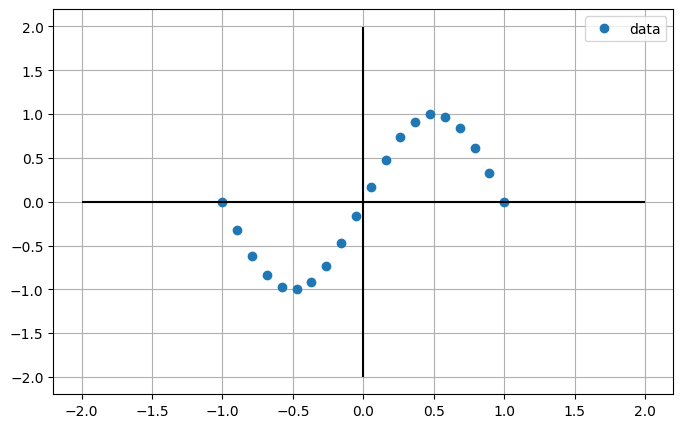

In [8]:
# @title
plt.figure(figsize = (8,5))
# 데이터 그리기
plt.plot(x, y, 'o', label = 'data')

# x축 y축 그리기
plt.vlines(x = 0,  ymin = y.min()-1, ymax = y.max()+1, color='k')
plt.hlines(y = 0,  xmin = x.min()-1, xmax = x.max()+1, color='k')
plt.grid()

# 범례 보여주기
plt.legend()

# 보여주기
plt.show()

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(1, 1),
)

n_epochs = 500

######### DO NOT CHANGE BELOW ########
optimizer = torch.optim.Adam(model.parameters())

model.train()
for e in tqdm(range(n_epochs)):
    out = model(torch.from_numpy(x).float().unsqueeze(1))
    loss = F.mse_loss(out, torch.from_numpy(y).float().unsqueeze(1))  # 손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
x_test = np.linspace(-1, 1, 50)
with torch.no_grad():
    y_pred = model(torch.from_numpy(x_test).float().unsqueeze(1))
    y_pred = y_pred.numpy()

plt.figure(figsize = (8, 5))
# 데이터 그리기
plt.scatter(x, y, label = 'data')
plt.plot(x_test, y_pred, 'r-', label = 'fitting-line')

# x축 y축 그리기
plt.vlines(x = 0,  ymin = y.min()-1, ymax = y.max()+1, color='k')
plt.hlines(y = 0,  xmin = x.min()-1, xmax = x.max()+1, color='k')
plt.grid()

# 범례 보여주기
plt.legend()

# 보여주기
plt.show()

## MLP를 이용한 손글씨 분류기 만들기
MLP를 시작으로 딥러닝 분야가 발달하면서 우리는 단순히 숫자 몇 개가 표현되는 데이터가 아닌 훨씬 복잡한 형태의 데이터를 입력받는 함수를 학습할 수 있게 되었어요. 복잡한 데이터의 대표적인 예시로 이미지가 있습니다. 우리는 다층 퍼셉트론을 이용하여 주어진 손글씨 사진에 어떤 숫자가 써있는지 알아 맞히는 모델을 만들어 볼 것입니다.

In [ ]:
# MNIST 데이터셋 로드
# 처음 로드 시 시간이 다소 소요될 수 있습니다.
(X_train, y_train), (X_test, y_test) =  mnist.load_data()
X_train = X_train[:30000]
y_train = y_train[:30000]

# 데이터를 0-1 사이로 스케일링 (픽셀 값 0~255를 255로 나눔)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"훈련 데이터 개수: {len(X_train)}")
print(f"테스트 데이터 개수: {len(X_test)}")

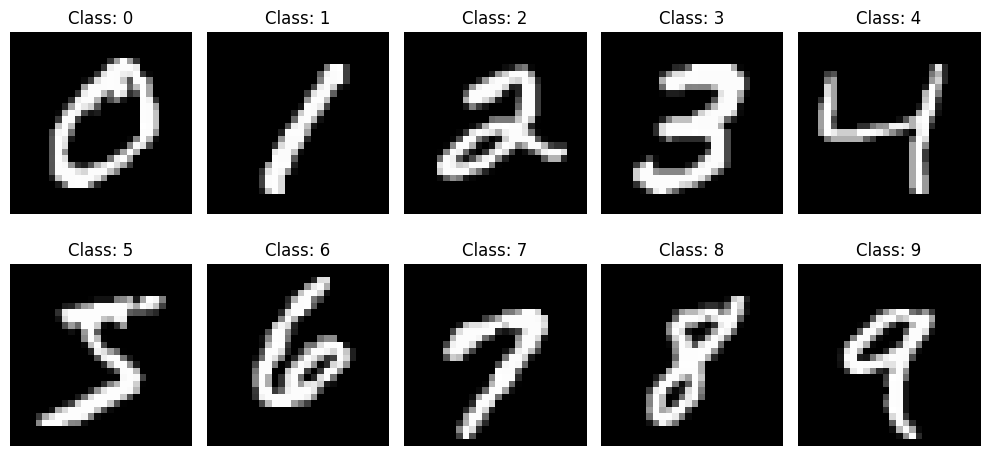

In [12]:
# @title
# MNIST 클래스 이름 (0부터 9까지)
mnist_class_names = [str(i) for i in range(10)]

# 각 클래스별 이미지 하나씩 보여주기
plt.figure(figsize=(10, 5))
for i in range(10):
    # 해당 클래스의 인덱스 찾기
    class_indices = np.where(y_train == i)[0]
    if len(class_indices) > 0:
        # 첫 번째 이미지 인덱스 선택
        img_index = class_indices[0]

        # 1차원 데이터를 28x28 이미지로 재구성
        img = X_train[img_index].reshape(28, 28)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Class: {mnist_class_names[i]}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score

def train_mlp(hidden_size=(100,), lr=0.1, num_iter=30, verbose=True):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_size,
                        learning_rate_init=lr,
                        max_iter=num_iter,
                        activation='logistic',
                        solver='sgd',
                        random_state=42,
                        verbose=verbose)

    print("MLP 모델 학습 중...")
    mlp.fit(X_train.reshape((len(X_train), -1)), y_train)
    print("학습 완료.")

    # 테스트 정확도 평가
    y_pred = mlp.predict(X_test.reshape((len(X_test), -1)))
    acc = accuracy_score(y_test, y_pred)
    print(f"테스트 정확도: {acc:.4f}")

    return mlp

In [ ]:
hidden_size = (64, 64)
lr = 0.005
num_iter = 10

mlp = train_mlp(hidden_size, lr, num_iter)

### 직접 그린 숫자 예측해보기

In [15]:
# @title
global_state = {}

def show_canvas_image(img):
    """
    그림 보여주기
    """
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Canvas Input")
    plt.show()

def set_prediction_output(text):
    js = f"""
    <script>
    document.getElementById('prediction-output').innerText = "{text}";
    </script>
    """
    display(HTML(js))

def preprocess_canvas_image(image):
    """
    Canvas 이미지 → 28×28 크기로 단순 변환 (MNIST 모델 입력용)
    중심이동, crop, 패딩 없이 가장 간단한 방식
    """
    img = image.resize((28, 28), Image.LANCZOS)  # PIL Image 그대로 resize
    img_np = np.array(img).astype(np.float32) / 255.0  # 정규화
    return img_np.reshape(1, -1)


def draw_canvas(model):
    global global_state
    global_state['model'] = model

    def get_image(data):
        header, base64_data = data.split(',', 1)
        binary = b64decode(base64_data)
        img = Image.open(io.BytesIO(binary)).convert('L')
        global_state['input_canvas'] = img
        img_np = preprocess_canvas_image(img)
        global_state['input_canvas_pre'] = img_np

        pred = model.predict(img_np)
        global_state['last_pred'] = pred[0]
        set_prediction_output(f"Predicted class: {pred[0]}")

    output.register_callback('notebook.get_image', get_image)

    display(Javascript('''
    (() => {
        ['canvas', 'predict-btn', 'erase-btn', 'prediction-output'].forEach(id => {
            const el = document.getElementById(id);
            if (el) el.remove();
        });

        const canvas = document.createElement('canvas');
        canvas.width = 280;
        canvas.height = 280;
        canvas.style.border = '2px solid black';
        canvas.id = 'canvas';
        document.body.appendChild(canvas);

        const ctx = canvas.getContext('2d');
        ctx.lineWidth = 15;
        ctx.lineCap = 'round';
        ctx.strokeStyle = 'white';

        let drawing = false;
        canvas.onmousedown = (e) => {
            drawing = true;
            ctx.beginPath();
            ctx.moveTo(e.offsetX, e.offsetY);
        };
        canvas.onmousemove = (e) => {
            if (drawing) {
                ctx.lineTo(e.offsetX, e.offsetY);
                ctx.stroke();
            }
        };
        canvas.onmouseup = () => drawing = false;
        canvas.onmouseout = () => drawing = false;

        const outputDiv = document.createElement('div');
        outputDiv.id = 'prediction-output';
        outputDiv.style.marginTop = '10px';
        outputDiv.innerText = '← Prediction will appear here';
        document.body.appendChild(outputDiv);

        const btnBox = document.createElement('div');
        btnBox.style.marginTop = '10px';

        const predictBtn = document.createElement('button');
        predictBtn.textContent = 'Predict';
        predictBtn.id = 'predict-btn';
        predictBtn.style.marginRight = '5px';
        btnBox.appendChild(predictBtn);

        predictBtn.onclick = () => {
            const data = canvas.toDataURL('image/png');
            google.colab.kernel.invokeFunction('notebook.get_image', [data], {});
        };

        const eraseBtn = document.createElement('button');
        eraseBtn.textContent = 'Erase';
        eraseBtn.id = 'erase-btn';
        btnBox.appendChild(eraseBtn);

        eraseBtn.onclick = () => {
            ctx.clearRect(0, 0, canvas.width, canvas.height);
            document.getElementById('prediction-output').innerText = '← Canvas cleared';
        };

        document.body.appendChild(btnBox);
    })()
    '''))

In [ ]:
# @title
draw_canvas(mlp)  # 손그림으로 테스트